# Automated Incident Investigation through NLP-Based Forensic Text Analysis using LSTM:


## 1. Importing Required Libraries

In this step, we import all the essential Python libraries used for building the Deep Learning (LSTM) model for forensic text classification. Each library serves a specific purpose in data handling, preprocessing, visualization, and model development.

In [13]:

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## 2. Loading the Dataset
 This step reads the cyber forensic text dataset from the CSV file and displays the first few rows to understand the structure and content of the data.

In [8]:
df = pd.read_csv("cybercrime_forensic_dataset.csv")
df.head()


,Timestamp,User_ID,IP_Address,Activity_Type,Resource_Accessed,File_Name,Action,Login_Attempts,File_Size,Anomaly_Type,Label
0,2024-09-27 12:53:26.390859,9288,10.174.236.5,File_Modification,/network/logs/new_project.docx,new_project.docx,Delete,NaN,30.66,DDoS_Attempt,Suspicious
1,2024-10-02 15:13:49.741543,1605,172.19.128.216,USB_Insert,/server/secrets.txt,NaN,Read,NaN,NaN,Brute_Force,Suspicious
2,2024-09-13 14:31:39.163288,3056,192.168.201.132,File_Modification,/project/document2.docx,document2.docx,NaN,NaN,21.61,DDoS_Attempt,Suspicious
3,2024-10-02 22:27:57.622008,1564,10.119.122.121,Network_Traffic,/backup/document2.docx,NaN,Delete,NaN,NaN,NaN,Normal
4,2024-10-01 08:00:55.017797,3660,172.23.2.38,USB_Insert,/confidential/report1.pdf,NaN,Write,NaN,NaN,NaN,Normal


## 3.Text Cleaning Function

This function preprocesses each forensic log entry by removing noise, masking sensitive patterns, and normalizing the text for NLP-based modeling.

In [9]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\b\d{1,3}(?:\.\d{1,3}){3}\b', ' <IP> ', text)  # replace IPs
    text = re.sub(r'user[_-]?\d+', ' <USER> ', text)               # replace usernames
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)             # remove URLs
    text = re.sub(r'[^a-z<> ]', ' ', text)                         # keep alphabets & tags
    text = re.sub(r'\s+', ' ', text).strip()
    return text


## 4. Merging Text Columns & Applying Text Cleaning

This step combines multiple forensic log fields into a single text string and then applies the clean_text() function to prepare the data for NLP-based classification.

In [10]:
text_cols = ['Activity_Type', 'Resource_Accessed', 'File_Name', 'Anomaly_Type']
df['text'] = df[text_cols].fillna('').astype(str).apply(lambda r: ' '.join(r.values), axis=1)
df['clean_text'] = df['text'].apply(clean_text)
df[['Label', 'clean_text']].head()



,Label,clean_text
0,Suspicious,file modification network logs new project doc...
1,Suspicious,usb insert server secrets txt brute force
2,Suspicious,file modification project document docx docume...
3,Normal,network traffic backup document docx
4,Normal,usb insert confidential report pdf


## 5. Tokenization and Sequence Preparation

This step converts cleaned text into numerical sequences using a tokenizer, handles out-of-vocabulary words, and pads sequences to a fixed length for LSTM input.

In [11]:
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])

lengths = [len(s) for s in sequences]
print(f"Average length: {np.mean(lengths):.2f}, Max: {np.max(lengths)}")

MAX_LEN = 120  # you can tune this
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')


Average length: 6.63, Max: 12


## 6. Label Encoding the Output Classes

This step converts categorical labels (e.g., Normal, Suspicious, Malicious) into numerical values so that they can be used for model training.

In [12]:
le = LabelEncoder()
y = le.fit_transform(df['Label'].astype(str))
print("Classes:", le.classes_)


Classes: ['Normal' 'Suspicious']


## 7. Train–Test Split (Creating Training and Testing Sets)

This step divides the processed dataset into training and testing sets. Training data is used to teach the model, while testing data evaluates how well the model performs on unseen samples.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## 8. Building the Bidirectional LSTM Classification Model

This step defines and compiles the Deep Learning model used to classify forensic text logs into their respective incident categories. A combination of Embedding, BiLSTM, and Dense layers enables the model to learn contextual patterns and sequence behavior effectively.

In [14]:
num_classes = len(le.classes_)

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN, trainable=True),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, MAX_LEN))
model.summary()


C:\Users\FARISHA K.R\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,559,746 (5.95 MB)

 Trainable params: 1,559,746 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Training the LSTM Model with Early Stopping & Checkpointing

This step trains the BiLSTM model using the prepared training data while applying callback mechanisms like EarlyStopping and ModelCheckpoint to prevent overfitting and ensure the best model is saved.

In [15]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[es, mc]
)


Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8346 - loss: 0.4225  

74/74 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8925 - loss: 0.2691 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.9993 - loss: 0.0051  

74/74 ━━━━━━━━━━━━━━━━━━━━ 67s 897ms/step - accuracy: 0.9996 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 2.4170e-05
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 1.0000 - loss: 3.5622e-04  

74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 934ms/step - accuracy: 1.0000 - loss: 1.8979e-04 - val_accuracy: 1.0000 - val_loss: 5.8593e-06
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 1.0000 - loss: 9.1158e-05 

74/74 ━━━━━━━━━━━━━━━━━━━━ 66s 896ms/step - accuracy: 1.0000 - loss: 6.8160e-05 - val_accuracy: 1.0000 - val_loss: 2.1314e-06
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 1.0000 - loss: 5.0698e-05  

74/74 ━━━━━━━━━━━━━━━━━━━━ 86s 944ms/step - accuracy: 1.0000 - loss: 5.7350e-05 - val_accuracy: 1.0000 - val_loss: 1.5942e-06
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 1.0000 - loss: 5.1088e-05  

74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 995ms/step - accuracy: 1.0000 - loss: 4.2962e-05 - val_accuracy: 1.0000 - val_loss: 8.4967e-07
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 1.0000 - loss: 2.4065e-05  

74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 1.0000 - loss: 1.9344e-05 - val_accuracy: 1.0000 - val_loss: 4.8922e-07
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 1.0000 - loss: 2.0075e-05     

74/74 ━━━━━━━━━━━━━━━━━━━━ 517s 7s/step - accuracy: 1.0000 - loss: 2.1433e-05 - val_accuracy: 1.0000 - val_loss: 4.1602e-07
Epoch 9/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 1.0000 - loss: 3.7511e-05 - val_accuracy: 1.0000 - val_loss: 6.2917e-07
Epoch 10/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 1.0000 - loss: 1.3111e-05  

74/74 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 1.0000 - loss: 1.2826e-05 - val_accuracy: 1.0000 - val_loss: 2.5866e-07
Epoch 11/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 1.0000 - loss: 8.5864e-06  

74/74 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 1.0000 - loss: 1.0151e-05 - val_accuracy: 1.0000 - val_loss: 1.4790e-07
Epoch 12/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 1.0000 - loss: 5.7890e-06  

74/74 ━━━━━━━━━━━━━━━━━━━━ 73s 989ms/step - accuracy: 1.0000 - loss: 6.1776e-06 - val_accuracy: 1.0000 - val_loss: 9.0716e-08
Epoch 13/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 1.0000 - loss: 4.7932e-06   

74/74 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 1.0000 - loss: 5.1942e-06 - val_accuracy: 1.0000 - val_loss: 7.4606e-08
Epoch 14/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 65s 874ms/step - accuracy: 1.0000 - loss: 1.0589e-05 - val_accuracy: 1.0000 - val_loss: 1.5938e-07
Epoch 15/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - accuracy: 1.0000 - loss: 6.9734e-06 

74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 932ms/step - accuracy: 1.0000 - loss: 6.1314e-06 - val_accuracy: 1.0000 - val_loss: 6.5243e-08


## 10. Evaluating the Trained LSTM Model on Test Data

After training, the best-performing model (saved earlier using ModelCheckpoint) is loaded and evaluated on the unseen test set. This step measures how well the model generalizes to new cyber forensic log samples.

In [16]:
model.load_weights('best_lstm_model.h5')
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 6.7498e-08
Test Accuracy: 100.00%
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1233
  Suspicious       1.00      1.00      1.00       247

    accuracy                           1.00      1480
   macro avg       1.00      1.00      1.00      1480
weighted avg       1.00      1.00      1.00      1480



## 11. Real-Time Incident Inference and Automated Extractive Summary

This section implements the end-to-end prediction pipeline, where the trained model takes a raw forensic log entry, predicts its category (Normal / Suspicious / Malicious), and — if abnormal — generates a short extractive summary highlighting key suspicious sentences.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def extractive_summary(text, top_n=2):
    sentences = re.split(r'(?<=[.!?]) +', text)
    if len(sentences) <= top_n:
        return ' '.join(sentences)
    vect = TfidfVectorizer(stop_words='english').fit_transform(sentences)
    scores = np.asarray(vect.sum(axis=1)).ravel()
    top_ids = np.argsort(scores)[-top_n:][::-1]
    return ' '.join([sentences[i] for i in sorted(top_ids)])


def infer_and_report(raw_text):
    cleaned = clean_text(raw_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    
    pred = model.predict(seq)
    cls_idx = np.argmax(pred, axis=1)[0]
    cls_label = le.inverse_transform([cls_idx])[0]
    
    report = f"Predicted Category: {cls_label}\n"
    if cls_label.lower() != "normal":
        summary = extractive_summary(raw_text)
        report += f"\nIncident Summary:\n{summary}"
    return report

# Example:
sample_text = df['text'].iloc[0]
print(infer_and_report(sample_text))


## 12. Saving Tokenizer and Label Encoder for Deployment

To use the trained model in a real-time system (API, dashboard, or separate script), you must save the Tokenizer and Label Encoder.

In [19]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)



## 13. Classification Report

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step 
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1233
  Suspicious       1.00      1.00      1.00       247

    accuracy                           1.00      1480
   macro avg       1.00      1.00      1.00      1480
weighted avg       1.00      1.00      1.00      1480



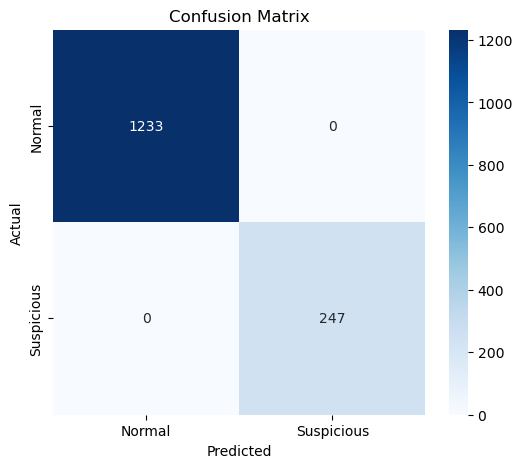

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate on test data
y_pred = np.argmax(model.predict(X_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 14. Incident Report Generation Function

The following function takes a raw incident log, preprocesses it, runs it through the trained LSTM model, and generates a structured forensic incident report.

In [21]:
def generate_incident_report(raw_text):
    cleaned = clean_text(raw_text)
    seq = tokenizer.texts_to_sequences([cleaned])
    seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    
    # Predict
    pred = model.predict(seq)
    cls_idx = np.argmax(pred, axis=1)[0]
    cls_label = le.inverse_transform([cls_idx])[0]
    
    # Extract summary
    summary = extractive_summary(raw_text)
    
    # Confidence
    confidence = float(np.max(pred))
    
    # Build report
    report = f"""
    ================================
              INCIDENT REPORT
    ================================
    Predicted Category : {cls_label}
    Confidence Score    : {confidence:.3f}

    Incident Summary
    --------------------
    {summary}

    Analysis
    --------------------
    The LSTM model identified this event as '{cls_label}'.
    Based on the textual evidence, the activity involves
    '{summary}', which suggests potential abnormal or risky
    behavior that warrants investigation.
    ================================
    """
    return report

# Example:
incident_text = df['text'].iloc[0]
print(generate_incident_report(incident_text))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

              INCIDENT REPORT
    Predicted Category : Suspicious
    Confidence Score    : 1.000

    Incident Summary
    --------------------
    File_Modification /network/logs/new_project.docx new_project.docx DDoS_Attempt

    Analysis
    --------------------
    The LSTM model identified this event as 'Suspicious'.
    Based on the textual evidence, the activity involves
    'File_Modification /network/logs/new_project.docx new_project.docx DDoS_Attempt', which suggests potential abnormal or risky
    behavior that warrants investigation.
    
